Monte-Carlo prediction and control for RL
Chapter 2, TensorFlow 2 Reinforcement Learning Cookbook | Praveen Palanisamy

In [1]:
import numpy as np

In [2]:
from envs.gridworldv2 import GridworldV2Env
from value_function_utils import (
    visualize_grid_action_values,
    visualize_grid_state_values,
)

In [3]:
def monte_carlo_prediction(env, max_episodes):
    returns = {state: [] for state in env.distinct_states}
    grid_state_values = np.zeros(len(env.distinct_states))
    grid_state_values[env.goal_state] = 1
    grid_state_values[env.bomb_state] = -1
    gamma = 0.99  # Discount factor
    for episode in range(max_episodes):
        g_t = 0
        state = env.reset()
        done = False
        trajectory = []
        while not done:
            action = env.action_space.sample()  # random policy
            next_state, reward, done = env.step(action)
            trajectory.append((state, reward))
            state = next_state

        for idx, (state, reward) in enumerate(trajectory[::-1]):
            g_t = gamma * g_t + reward
            # first visit Monte-Carlo prediction
            if state not in np.array(trajectory[::-1])[:, 0][idx + 1 :]:
                returns[str(state)].append(g_t)
                grid_state_values[state] = np.mean(returns[str(state)])
    visualize_grid_state_values(grid_state_values.reshape((3, 4)))

In [4]:
def epsilon_greedy_policy(action_logits, epsilon=0.2):
    idx = np.argmax(action_logits)
    probs = []
    epsilon_decay_factor = np.sqrt(sum([a ** 2 for a in action_logits]))

    if epsilon_decay_factor == 0:
        epsilon_decay_factor = 1.0
    for i, a in enumerate(action_logits):
        if i == idx:
            probs.append(round(1 - epsilon + (epsilon / epsilon_decay_factor), 3))
        else:
            probs.append(round(epsilon / epsilon_decay_factor, 3))
    residual_err = sum(probs) - 1
    residual = residual_err / len(action_logits)

    return np.array(probs) - residual

In [5]:
def monte_carlo_control(env, max_episodes):
    grid_state_action_values = np.zeros((12, 4))
    grid_state_action_values[3] = 1
    grid_state_action_values[7] = -1

    possible_states = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]
    possible_actions = ["0", "1", "2", "3"]
    returns = {}
    for state in possible_states:
        for action in possible_actions:
            returns[state + ", " + action] = []

    gamma = 0.99
    for episode in range(max_episodes):
        g_t = 0
        state = env.reset()
        trajectory = []
        while True:
            action_values = grid_state_action_values[state]
            probs = epsilon_greedy_policy(action_values)
            action = np.random.choice(np.arange(4), p=probs)  # random policy

            next_state, reward, done = env.step(action)
            trajectory.append((state, action, reward))

            state = next_state
            if done:
                break

        for step in reversed(trajectory):
            g_t = gamma * g_t + step[2]
            returns[str(step[0]) + ", " + str(step[1])].append(g_t)
            grid_state_action_values[step[0]][step[1]] = np.mean(
                returns[str(step[0]) + ", " + str(step[1])]
            )
    visualize_grid_action_values(grid_state_action_values)

===Monte Carlo Prediction===


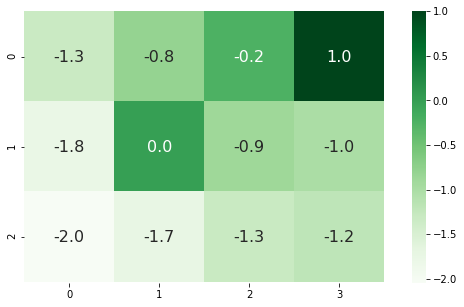

===Monte Carlo Control===


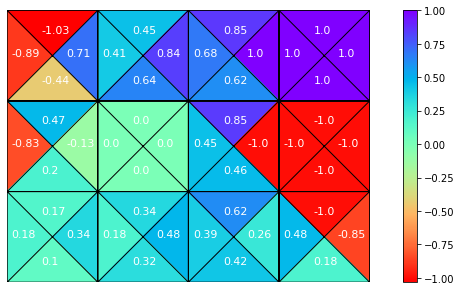

In [6]:
if __name__ == "__main__":
    max_episodes = 4000
    env = GridworldV2Env(step_cost=-0.1, max_ep_length=30)
    print(f"===Monte Carlo Prediction===")
    monte_carlo_prediction(env, max_episodes)
    print(f"===Monte Carlo Control===")
    monte_carlo_control(env, max_episodes)